In [ ]:
import torch
import torch.nn as nn # type: ignore

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [ ]:
netG = ResNetGenerator()
model_data = torch.load('../data/p1ch2/horse2zebra_0.4.0.pth')
netG.load_state_dict(model_data)

./表示当前目录 ../表示上级目录

In [ ]:
netG.eval()


In [ ]:
from PIL import Image
from torchvision import transforms


In [ ]:
processing = transforms.Compose([transforms.Resize(256),
transforms.ToTensor(),transforms.CenterCrop(224)])
img=Image.open('../data/p1ch2/horse.jpg')
img

In [ ]:
img_t=processing(img)
img_t.shape
batch_t=torch.unsqueeze(img_t,0)
batch_t.shape


# 假设 img_t 的形状是 (256, 256, 3)
img_t = img_t.permute(2, 0, 1)  # 将通道维度移到前面，形状变为 (3, 256, 256)
img_t = img_t.unsqueeze(0)  # 在第一个维度上添加一个维度，形状变为 (1, 3, 256, 256)
batch_t = img_t.repeat(2, 1, 1, 1)  # 复制张量以匹配新的形状，形状变为 (2, 3, 256, 256)

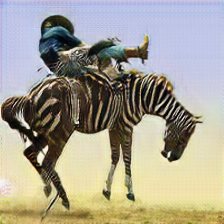

In [28]:
batch_out=netG(batch_t)
out_t = (batch_out.data.squeeze()+1)/2
 #将数据范围从[-1, 1]变为[0, 1]。这是因为神经网络通常使用[-1, 1]的范围进行计算
out_img = transforms.ToPILImage()(out_t)
out_img